<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/mars_challenge/camera_motion_compensation_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Camera Motion Compensation**

### **What is Camera Motion Compensation?**

In this notebook we will learn about camera motion compensation (CMC). In CMC, the objective is to describe the relative motion of a camera between two consecutive image frames. We can describe this motion through something called a Rigid Body Transformation, which is nothing more than a translation plus a rotation in the x-y plane. NOTE: A Rigid Body Transformation is an Affine transformation, meaning that it preserves points, straight lines, and planes.

### **How do we get the Rigid body (Affine) Transformation?**
We can get the Rigid Body Transformation by finding points of interest in the previous frame and comparing their location in the current frame. We can find by the points of interest with something called corner detection (Shi-Thomasi, Harris, FAST, etc). We can find the locations of the points on the current frame with Sparse Optical Flow, in this case we will use Lucas-Kanande Optical Flow. We choose optical flow in favor of feature matching, since optical flow is able to give reasonable results for a seuqence of videos. We assume that the frame reate will be high enough to produce sequences where the features are relatively close together. Feature matching is better suited for lower frame rates and situations where scene are captured from different view points. See this [stackoverflow](https://stackoverflow.com/questions/47465570/opencv-feature-matching-vs-optical-flow) for mroe details.

Once we have the points in both the previous and current frames, we can then compute the Rigid Body Transformation Matrix, a 2x3 matrix.  We will use the opencv function estimateAffinePartial2D() to do this. It will estiamte the optimal affine transformation between both sets of points. This will give us our resulting affine transformation that we have been looking for.

### **What can we do with camera motion compensation?**
- Improve Visual Tracking accuracy with a moving camera
- Estimate speed of moving camera
- Digital Video Stabilization


### **Download the data!**

For the data, we will use the training video from the [MARS challenge](https://blog.marsauto.com/introducing-the-mars-challenge-fc84c5afafbe)

In [1]:
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.mp4

--2023-08-26 18:46:13--  https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.mp4
Resolving marschallenge.s3.ap-northeast-2.amazonaws.com (marschallenge.s3.ap-northeast-2.amazonaws.com)... 52.219.56.132, 52.219.146.62, 52.219.204.82, ...
Connecting to marschallenge.s3.ap-northeast-2.amazonaws.com (marschallenge.s3.ap-northeast-2.amazonaws.com)|52.219.56.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 450765182 (430M) [video/mp4]
Saving to: ‘train.mp4’

train.mp4           100%[===================>] 429.88M  11.0MB/s    in 40s     

2023-08-26 18:46:54 (10.8 MB/s) - ‘train.mp4’ saved [450765182/450765182]



### **Import Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

#### Load part of train video into memory

In [3]:
cap = cv2.VideoCapture("train.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(image)

        if i == 2000:
            break
        else:
           i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()

In [4]:
len(frames)

2001

In [5]:
frame1 = frames[1000]
frame2 = frames[1001]

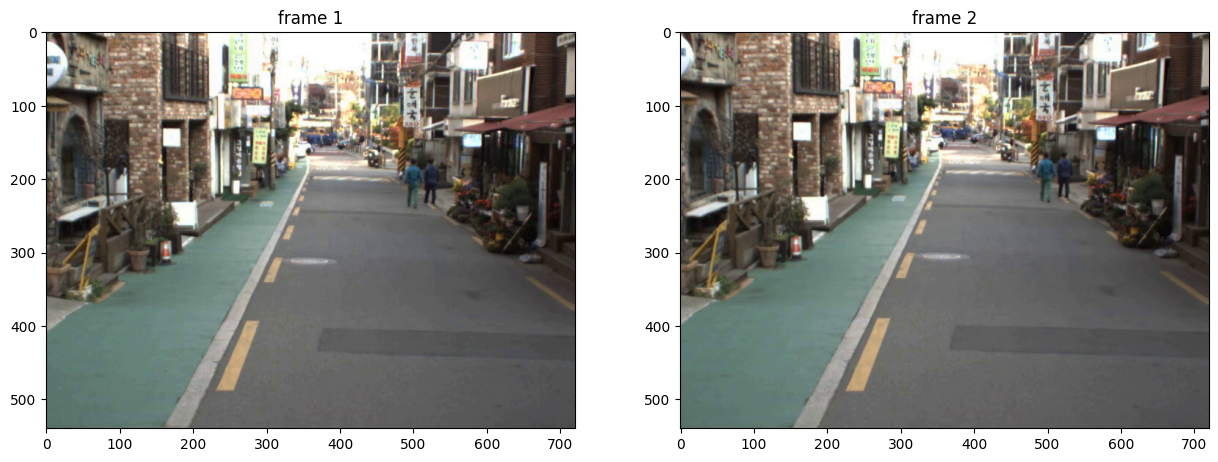

In [6]:
_, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(frame1)
ax[0].set_title("frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

In [7]:
gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

In [62]:
corners = cv2.goodFeaturesToTrack(gray1, 100, qualityLevel=0.01, minDistance=10)

In [148]:
# higher threshold would generally provide faster computation
fast = cv2.FastFeatureDetector_create(threshold=7)
kp = fast.detect(gray1, None)

In [76]:
%timeit fast.detect(gray1, None)

385 µs ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [65]:
%timeit cv2.goodFeaturesToTrack(gray1, 100, qualityLevel=0.01, minDistance=10)

8.18 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [106]:
# get integer key point locations
corners = cv2.KeyPoint_convert(kp)

In [107]:
corners.min(), corners.max(), corners.shape, gray1.shape

(3.0, 649.0, (212, 2), (540, 720))

We will use the FAST corner detector. It is not as Robust as Shi-Tomasi, but it will get us most of the features/keypoints most of the time at a very fast speed. It turns out that we really only need 50-100 keypoints to accuratley compute the translation and rotation between frames.

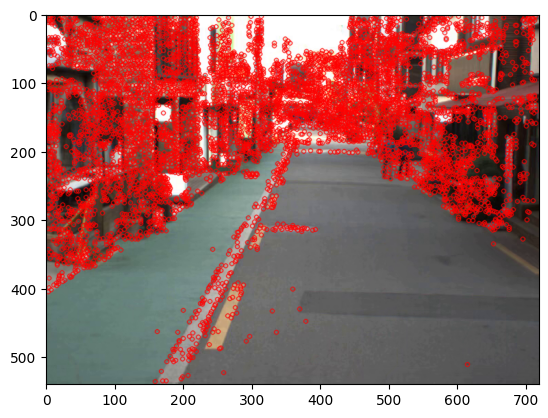

In [149]:
frame1_copy = cv2.drawKeypoints(frame1, kp, None, color=(255,0,0))
plt.imshow(frame1_copy);

In [121]:
 matched_corners, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, corners, None)

In [110]:
matched_corners.shape

(212, 2)

In [122]:
status = status.reshape((-1))

In [112]:
prev_points = corners.reshape((-1, 2))[status==1]
curr_points = matched_corners.reshape((-1, 2))[status==1]

In [113]:
A, _ = cv2.estimateAffinePartial2D(prev_points, curr_points, method=cv2.RANSAC)

In [114]:
A

array([[ 1.01005049e+00,  2.22729797e-03, -6.28538911e+00],
       [-2.22729797e-03,  1.01005049e+00, -9.07974553e+00]])

In [ ]:
# Transformation computed with 100 Shi-Thomasi features#
A

array([[ 1.00832172e+00,  5.26935058e-03, -5.61726431e+00],
       [-5.26935058e-03,  1.00832172e+00, -7.60121952e+00]])

In [ ]:
gray1.shape

(540, 720)

In [115]:
# transform previous frame to current frame position
transformed_1 = cv2.warpAffine(frame1, A, dsize=(gray1.shape[::-1]))
transformed_1_gray = cv2.warpAffine(gray1, A, dsize=(gray1.shape[::-1]))

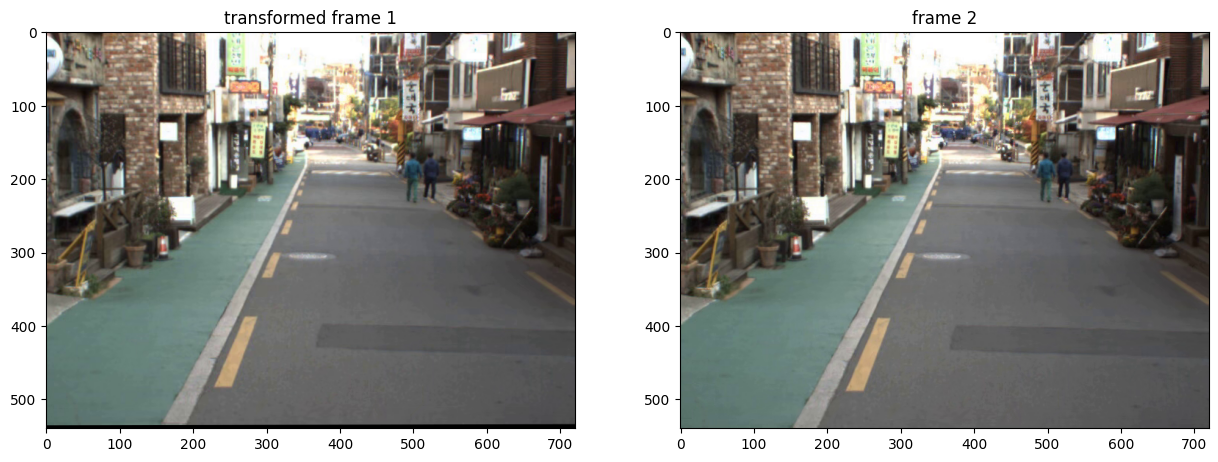

In [116]:
_, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(transformed_1)
ax[0].set_title("transformed frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

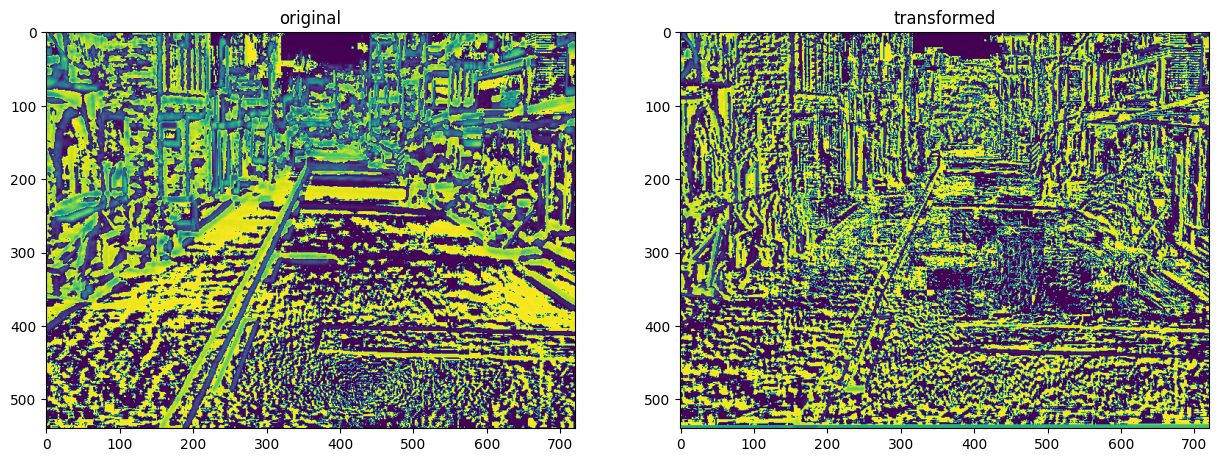

In [117]:
_, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(gray1 - gray2)
ax[0].set_title("original")
ax[1].imshow(transformed_1_gray - gray2)
ax[1].set_title("transformed");

In [118]:
np.mean(gray1 - gray2), np.mean(transformed_1_gray - gray2)

(121.94808899176955, 115.16297067901235)

In [119]:
np.median(gray1 - gray2), np.median(transformed_1_gray - gray2)

(90.0, 12.0)

In [120]:
np.std(gray1 - gray2), np.std(transformed_1_gray - gray2)

(112.30854512835631, 122.60460439665994)

# **Create pipeline**

In [132]:
def compute_motion(frame1 : np.ndarray, frame2 : np.ndarray, method : int, params : dict) -> np.ndarray:
    """
    Computes motion compensation transformation matrix (a rigid body transform)
    from frame 1 to frame 2
    Inputs:
      frame 1 - first grayscale frame
      frame 2 - second grayscale frame
      method - determines the method of feature detection
      params - parameters for feature detection

    """

    # get corners of first image
    if method == 0:
        fast = cv2.FastFeatureDetector_create(**params)
        corners = cv2.KeyPoint_convert(fast.detect(frame1, None))
    elif method == 1:
        corners = cv2.goodFeaturesToTrack(frame1, **params)

    # get matching features on next image
    matched_corners, status, error = cv2.calcOpticalFlowPyrLK(frame1, frame2, corners, None)

    # get valid matched features
    status = status.reshape((-1))
    prev_points = corners.reshape((-1, 2))[status==1]
    curr_points = matched_corners.reshape((-1, 2))[status==1]

    # estimate transformation matrix from frame 1 to frame 2
    A, _ = cv2.estimateAffinePartial2D(prev_points, curr_points, method=cv2.RANSAC)

    return A


### Test Pipeline

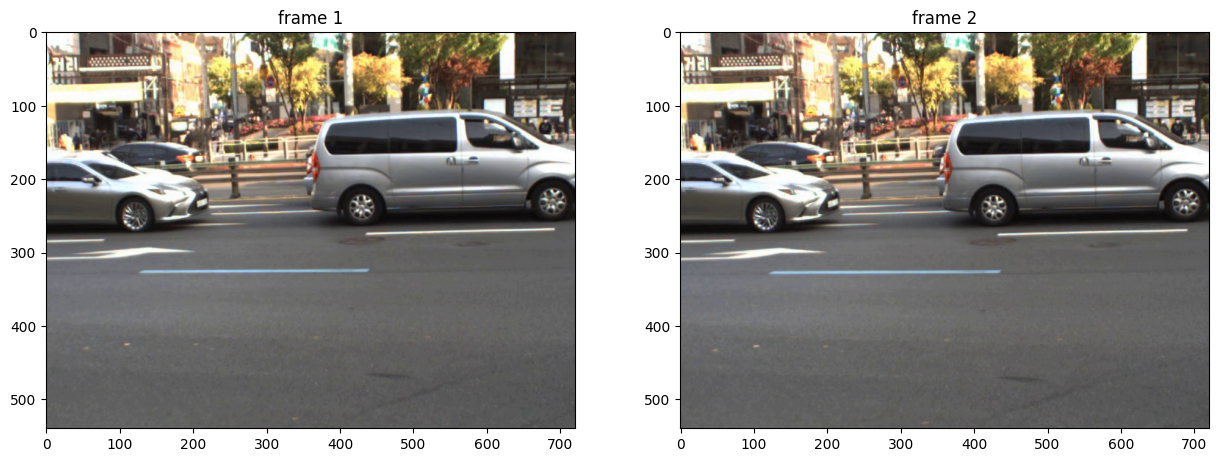

In [213]:
# 1800 -> failure case, bus is moving horizontally but vehicle is stopped
idx = 1700

frame1 = frames[idx]
frame2 = frames[idx + 1]

gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

_, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(frame1)
ax[0].set_title("frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

In [214]:
shi_thomasi_params = {'maxCorners' : 100, 'qualityLevel' : 0.01, 'minDistance' : 10}
fast_params = {'threshold' : 10}

A_fast = compute_motion(gray1, gray2, method=0, params=fast_params)
A_shi_thomasi = compute_motion(gray1, gray2, method=1, params=shi_thomasi_params)

In [215]:
A_fast, A_shi_thomasi, A_fast - A_shi_thomasi

(array([[ 1.00290383e+00, -1.47481651e-03, -3.85374991e+00],
        [ 1.47481651e-03,  1.00290383e+00, -6.92414091e-01]]),
 array([[ 1.00385583e+00, -1.75598193e-03, -4.05115691e+00],
        [ 1.75598193e-03,  1.00385583e+00, -8.81278202e-01]]),
 array([[-0.00095201,  0.00028117,  0.197407  ],
        [-0.00028117, -0.00095201,  0.18886411]]))

In [216]:
transformed_1_fast = cv2.warpAffine(frame1, A_fast, dsize=(gray1.shape[::-1]))
transformed_1_shi_thomasi = cv2.warpAffine(frame1, A_shi_thomasi, dsize=(gray1.shape[::-1]))

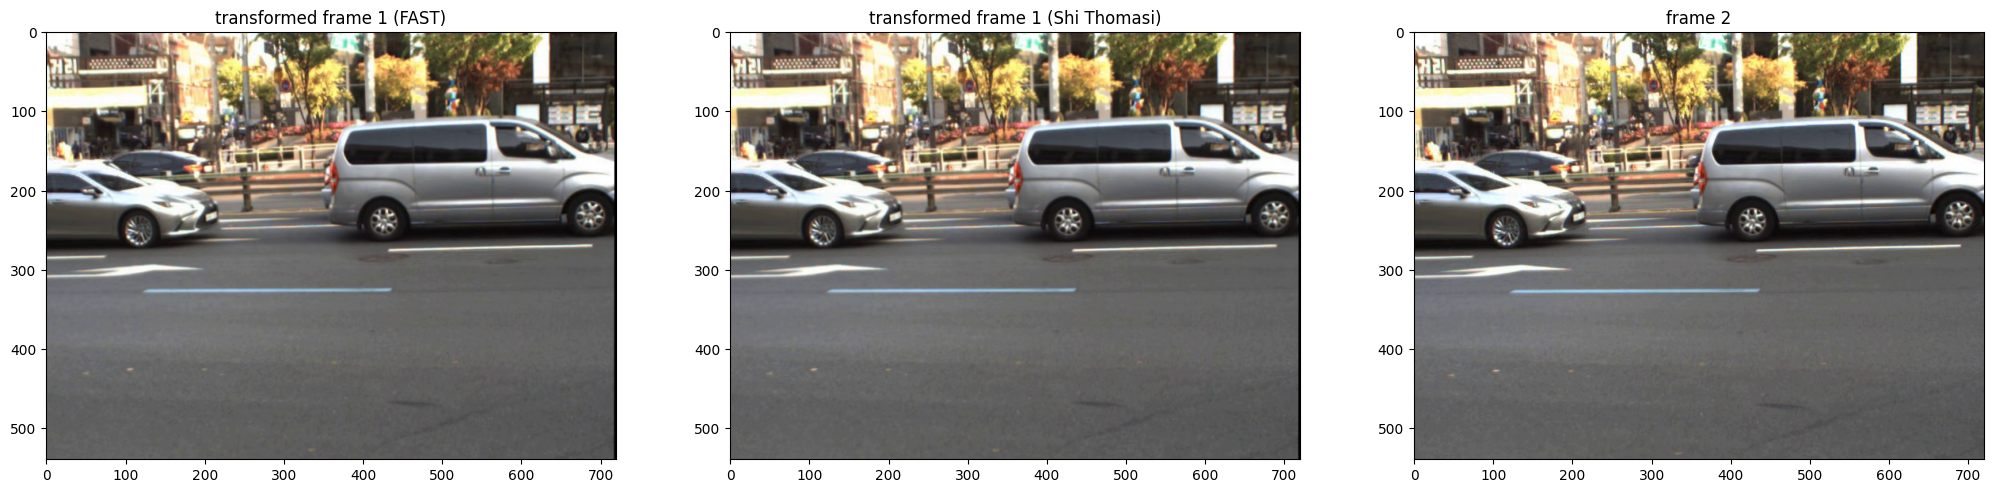

In [217]:
_, ax = plt.subplots(1, 3, figsize=(25,15))
ax[0].imshow(transformed_1_fast)
ax[0].set_title("transformed frame 1 (FAST)")
ax[1].imshow(transformed_1_shi_thomasi)
ax[1].set_title("transformed frame 1 (Shi Thomasi)")
ax[2].imshow(frame2)
ax[2].set_title("frame 2");

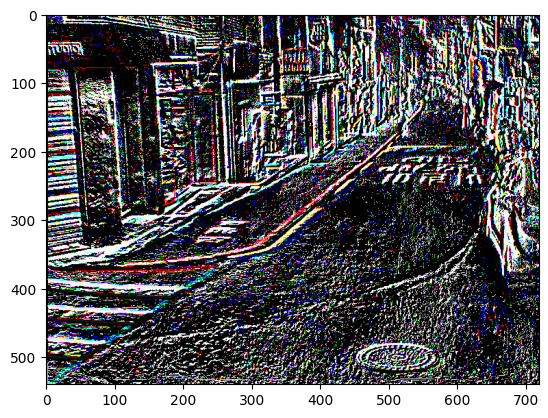

In [201]:
plt.imshow(transformed_1_fast - transformed_1_shi_thomasi);

In [172]:
(transformed_1_fast - transformed_1_shi_thomasi).min(), (transformed_1_fast - transformed_1_shi_thomasi).max(), (transformed_1_fast - transformed_1_shi_thomasi).mean()

(0, 255, 81.04889146090535)

# **References**

- https://arxiv.org/pdf/2302.11813.pdf
- https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html
- https://docs.opencv.org/3.4/d4/d8c/tutorial_py_shi_tomasi.html
- https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html
- https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
- https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.htmhttps://www.mathworks.com/discovery/affine-transformation.html